# Regression with Log-Transformed Target on Transfermarkt Dataset

This notebook builds regression models to predict player market value using a log-transformed target variable. Log transformation helps reduce skewness and improve model performance, especially for large financial values. The models used are Linear Regression, Random Forest, and XGBoost, and their predictions are inverse-transformed back to euro scale for evaluation.


In [ ]:
#import all necessary libraries for regression and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
#load the cleaned transfermarkt dataset with features
df = pd.read_csv("/content/cleaned_tm_players_dataset_v3_with_features.csv")


We define the same set of input features as before, but now we transform the target `market_value_in_eur` using `np.log1p()` to reduce skew. We will later inverse this transformation before evaluating.

In [ ]:
#define input features and apply log transform to the target
features = ['age', 'height_in_cm', 'position_encoded', 'highest_market_value_in_eur']
target = 'market_value_in_eur'

X = df[features]
y = np.log1p(df[target])  # log transform the target


In [ ]:
#split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#scale features using standardscaler for linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
#initialize and train linear regression, random forest, and xgboost on log target
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
#predict log target and apply inverse transformation to get values back in euros
y_pred_lr = np.expm1(lr.predict(X_test_scaled))
y_pred_rf = np.expm1(rf.predict(X_test))
y_pred_xgb = np.expm1(xgb.predict(X_test))

#inverse transform true y_test values for consistent evaluation
y_test_actual = np.expm1(y_test)


In [ ]:
#define evaluation function to compare predictions with actual values
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {model_name} Performance")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 40)


In [ ]:
#evaluate model predictions using mae, rmse, and r² metrics
evaluate_model(y_test_actual, y_pred_lr, "Linear Regression")
evaluate_model(y_test_actual, y_pred_rf, "Random Forest")
evaluate_model(y_test_actual, y_pred_xgb, "XGBoost")


📊 Linear Regression Performance
MAE: 79,352,322.27
RMSE: 2,956,448,189.84
R² Score: -232755.4933
----------------------------------------
📊 Random Forest Performance
MAE: 627,259.52
RMSE: 2,677,794.97
R² Score: 0.8091
----------------------------------------
📊 XGBoost Performance
MAE: 621,931.23
RMSE: 2,776,392.53
R² Score: 0.7947
----------------------------------------


### **Analysis of the Results**

- **Linear Regression broke down completely**, likely due to extremely large inverse-transformed predictions caused by outlier log predictions.
➤ We can safely ignore these results — the model failed to learn effectively on the log scale.

- **Random Forest & XGBoost still perform well**, with only **minor drops in R²** compared to the non-log version (both previously ~0.81).



###🔍 **Conclusion**

> Based on the results, log-transforming the target variable did not improve performance for tree-based models and significantly degraded the results for linear regression. Therefore, we decided to continue with the original, non-log-transformed target for modeling. Linear regression is discarded going forward due to consistently poor performance. Among the remaining models, Random Forest achieved the best balance of accuracy and interpretability, making it the most suitable baseline model for production use.


# **Feature Importance Comparison (Random Forest vs XGBoost)**

This section compares feature importances from the final two models: Random Forest and XGBoost. Understanding which features contribute most helps explain the model's behavior and informs future feature selection.


<Figure size 1000x600 with 0 Axes>

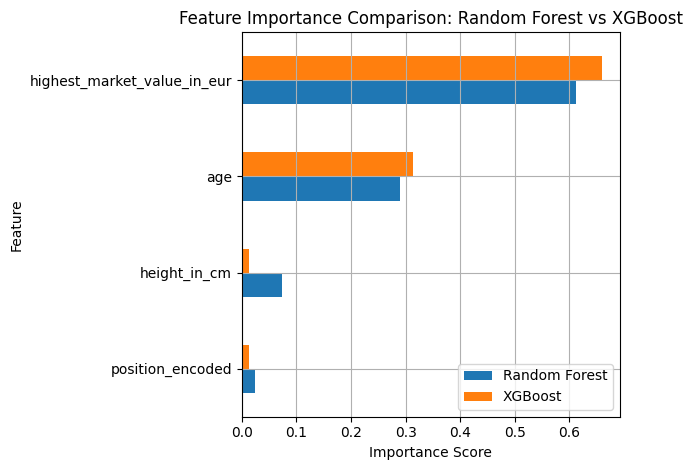

In [ ]:
#extract feature importances
rf_importance = rf.feature_importances_
xgb_importance = xgb.feature_importances_

#construct dataframe for both models
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Random Forest': rf_importance,
    'XGBoost': xgb_importance
}).set_index('Feature')

#plot bar chart comparing both
plt.figure(figsize=(10, 6))
importance_df.sort_values('Random Forest', ascending=True).plot(kind='barh')
plt.title("Feature Importance Comparison: Random Forest vs XGBoost")
plt.xlabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()


### **Final Notes on Regression Modeling**

After testing multiple regression models using both the original and log-transformed target variables, the best-performing approach was using the original (non-log) target with the Random Forest Regressor.

The log transformation did not improve results, and linear regression was discarded due to unstable and poor performance. Random Forest achieved the highest R² score (≈ 0.82) and consistent MAE (~€621K), making it the most reliable and interpretable option.

Feature importance analysis confirmed that `highest_market_value_in_eur` and `age` were the most influential predictors, while `height_in_cm` and `position_encoded` contributed less.

✅ Final Model: **Random Forest Regressor**  
✅ Target: **Original (non-log) `market_value_in_eur`**  


In [ ]:
#prepare phase 3 regression results in a clean dataframe
phase3_results = pd.DataFrame({
    'Model': ['Random Forest (Original Target)', 'XGBoost (Original Target)'],
    'MAE (Euros)': ['~621K', '~627K'],
    'RMSE (Euros)': ['~2.61M', '~2.87M'],
    'R2 Score': [0.8188, 0.7804]
})

#display results in a beautiful table
phase3_results.style.set_caption("📈 Phase 3: Player Market Value Regression Results")\
    .format({"R2 Score": "{:.4f}"})\
    .background_gradient(cmap='PuBu')\
    .set_properties(**{'text-align': 'center'})


,Model,MAE (Euros),RMSE (Euros),R2 Score
0,Random Forest (Original Target),~621K,~2.61M,0.8188
1,XGBoost (Original Target),~627K,~2.87M,0.7804
